# Autoencoders [Keras]
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [autoencoder_Keras.ipynb](https://github.com/diegoinacio/machine-learning-notebooks/blob/master/Deep-Learning-Models/autoencoder_Keras.ipynb)
---
Exploration of some *autoencoder* architectures.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)

## Data exploration
---

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
[X_train, Y_train],[X_test, Y_test] = fashion_mnist.load_data()

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


In [4]:
# Label categories
objects = [
    'T-shirt/top', 'Trouser/pants',
    'Pullover shirt', 'Dress',
    'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle', 'boot'
]

# Get dimensions
N1, N2 = X_train[0].shape

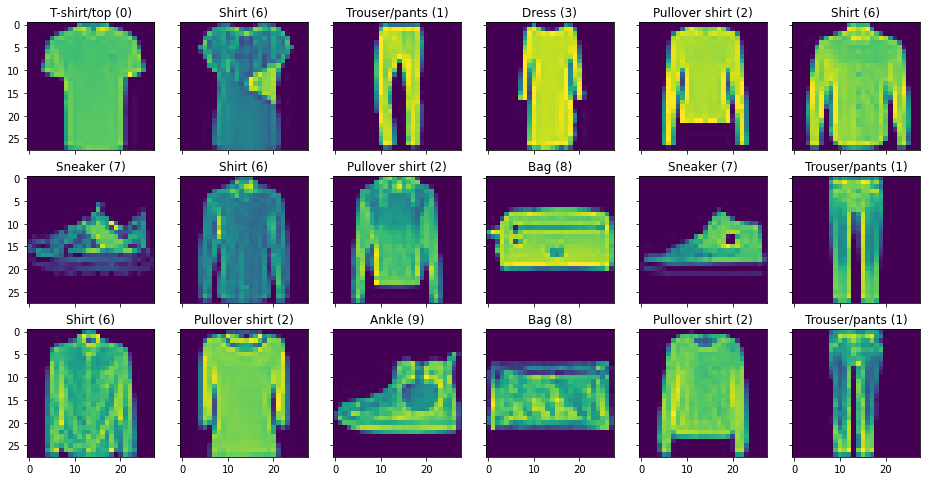

In [5]:
fig, AX = plt.subplots(3, 6, sharex=True, sharey=True)

np.random.seed(12345)
for ax in AX.ravel():
    rindex = np.random.randint(Y_train.size)
    ax.imshow(X_train[rindex])
    label = Y_train[rindex]
    ax.set_title(f'{objects[label]} ({label})')
plt.grid(False)

In [6]:
# data preparation
# scales, dimensions and dtypes
x_train, X_train = [X_train/255]*2
x_test, X_test = [X_test/255]*2

x_train = x_train.astype(np.float32).reshape(-1, N1*N2)
X_train = X_train.astype(np.float32).reshape(-1, N1, N2, 1)
x_test = x_test.astype(np.float32).reshape(-1, N1*N2)
X_test = X_test.astype(np.float32).reshape(-1, N1, N2, 1)

print('x_train:', x_train.shape)
print('X_train:', X_train.shape)
print('x_test:', x_test.shape)
print('X_test:', X_test.shape)

x_train: (60000, 784)
X_train: (60000, 28, 28, 1)
x_test: (10000, 784)
X_test: (10000, 28, 28, 1)


## Shallow Autoencoder
---
![shallow autoencoder](sourceimages/autoencoder_shallow.png "Shallow Autoencoder")

In [7]:
# Number of neurons on the bottleneck hidden layer
neurons = 64

# m is the number of examples
# n_x is the input size 28x28=784
m, n_x = x_train.shape

# Model
encoder_s = tf.keras.Sequential([
    tf.keras.layers.Input(n_x),
    tf.keras.layers.Dense(neurons, activation='relu')
], name='Shallow-Encoder')

decoder_s = tf.keras.Sequential([
    tf.keras.layers.Input(neurons),
    tf.keras.layers.Dense(n_x, activation='sigmoid')
], name='Shallow-Decoder')


autoencoder_s = tf.keras.Sequential([
    encoder_s.input,
    encoder_s.layers[0],
    decoder_s.input,
    decoder_s.layers[0]
], name='Shallow-Autoencoder')

autoencoder_s.summary()

Model: "Shallow-Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile model
autoencoder_s.compile(
    optimizer='adadelta',
    loss='binary_crossentropy'
)

# Train model
for i in range(5):
    print(f'\nepochs: {i*100:04d} - {(i + 1)*100:04d}')
    autoencoder_s.fit(
        x_train, x_train,
        epochs=99,
        verbose=0
    )
    autoencoder_s.fit(
        x_train, x_train,
        epochs=1,
        validation_data=(x_test, x_test)
    )


epochs: 0000 - 0100
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 63us/sample - loss: 0.4686 - val_loss: 0.4688

epochs: 0100 - 0200
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 63us/sample - loss: 0.4114 - val_loss: 0.4123

epochs: 0200 - 0300
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3917 - val_loss: 0.3929

epochs: 0300 - 0400
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 65us/sample - loss: 0.3769 - val_loss: 0.3783

epochs: 0400 - 0500
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 65us/sample - loss: 0.3648 - val_loss: 0.3665


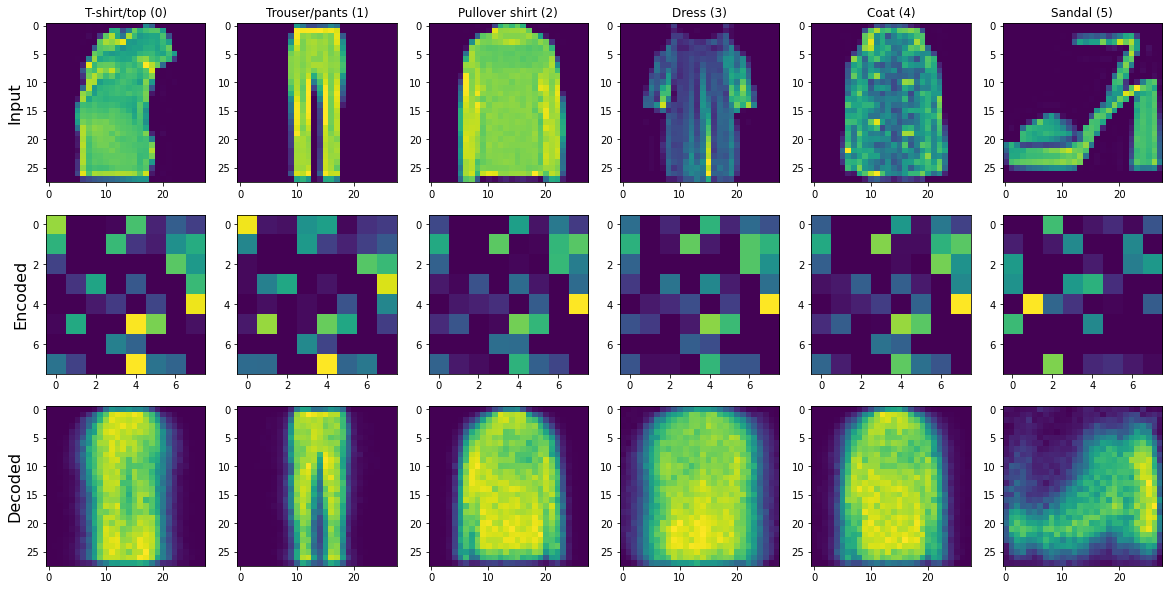

In [9]:
fig, AX = plt.subplots(3, 6, figsize=(20, 10))

np.random.seed(1234)
for i in range(6):
    index = np.argwhere(Y_test == i)[:,0]
    index = np.random.choice(index)
    label = Y_test[index]
    
    AX[0][i].imshow(X_test[index][...,0])
    AX[0][i].set_title(f'{objects[label]} ({label})')
    if not i: AX[0][i].set_ylabel('Input', size=16)
    
    encoded = encoder_s.predict(x_test[index].reshape(1, -1))
    
    AX[1][i].imshow(encoded.reshape(8, 8))
    if not i: AX[1][i].set_ylabel('Encoded', size=16)
    
    decoded = decoder_s.predict(encoded)
    
    AX[2][i].imshow(decoded.reshape(N1, N2))
    if not i: AX[2][i].set_ylabel('Decoded', size=16)

## Deep Autoencoder
---
![deep autoencoder](sourceimages/autoencoder_deep.png "Deep Autoencoder")

In [10]:
# m is the number of examples
# n_x is the input size 28x28=784
m, n_x = x_train.shape

# Model
encoder_d = tf.keras.Sequential([
    tf.keras.layers.Input(n_x),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu')
], name='Deep-Encoder')

decoder_d = tf.keras.Sequential([
    tf.keras.layers.Input(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(n_x, activation='sigmoid')
], name='Deep-Decoder')


autoencoder_d = tf.keras.Sequential([
    encoder_d.input,
    *encoder_d.layers,
    decoder_d.input,
    *decoder_d.layers
], name='Deep-Autoencoder')

autoencoder_d.summary()

Model: "Deep-Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
input_4 (InputLayer)         multiple                  0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)          

In [11]:
# Compile model
autoencoder_d.compile(
    optimizer='adadelta',
    loss='binary_crossentropy'
)

# Train model
for i in range(5):
    print(f'\nepochs: {i*100:04d} - {(i + 1)*100:04d}')
    autoencoder_d.fit(
        x_train, x_train,
        epochs=99,
        verbose=0
    )
    autoencoder_d.fit(
        x_train, x_train,
        epochs=1
    )


epochs: 0000 - 0100
Train on 60000 samples
60000/60000 [==============================] - 5s 87us/sample - loss: 0.3998

epochs: 0100 - 0200
Train on 60000 samples
60000/60000 [==============================] - 4s 74us/sample - loss: 0.3569

epochs: 0200 - 0300
Train on 60000 samples
60000/60000 [==============================] - 5s 76us/sample - loss: 0.3433

epochs: 0300 - 0400
Train on 60000 samples
60000/60000 [==============================] - 4s 75us/sample - loss: 0.3283

epochs: 0400 - 0500
Train on 60000 samples
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3210


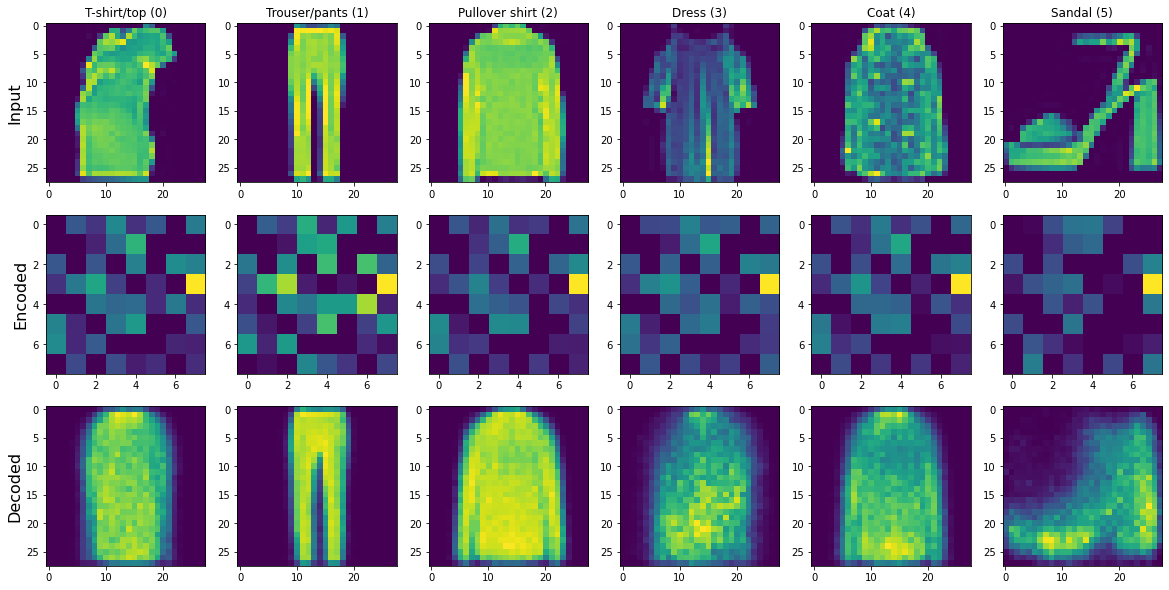

In [12]:
fig, AX = plt.subplots(3, 6, figsize=(20, 10))

np.random.seed(1234)
for i in range(6):
    index = np.argwhere(Y_test == i)[:,0]
    index = np.random.choice(index)
    label = Y_test[index]
    
    AX[0][i].imshow(X_test[index][...,0])
    AX[0][i].set_title(f'{objects[label]} ({label})')
    if not i: AX[0][i].set_ylabel('Input', size=16)
    
    encoded = encoder_d.predict(x_test[index].reshape(1, -1))
    
    AX[1][i].imshow(encoded.reshape(8, 8))
    if not i: AX[1][i].set_ylabel('Encoded', size=16)
    
    decoded = decoder_d.predict(encoded)
    
    AX[2][i].imshow(decoded.reshape(N1, N2))
    if not i: AX[2][i].set_ylabel('Decoded', size=16)

## Convolutional Autoencoder
---
![convolutional autoencoder](sourceimages/autoencoder_convolutional.png "Convolutional Autoencoder")

In [13]:
# Avoid error: "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize,
#               so try looking to see if a warning log message was printed above."
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [14]:
# Model
encoder_c = tf.keras.Sequential([
    
    tf.keras.layers.Input((N1, N2, 1)),
    tf.keras.layers.Convolution2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    tf.keras.layers.Convolution2D(8, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    tf.keras.layers.Convolution2D(3, kernel_size=(3,3), padding='same', activation='relu')
], name='Convolutional-Encoder')

decoder_c = tf.keras.Sequential([
    tf.keras.layers.Input((7, 7, 3)),
    tf.keras.layers.Convolution2D(8, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.Convolution2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.Convolution2D(1, kernel_size=(3,3), padding='same', activation='sigmoid')
], name='Convolutional-Decoder')


autoencoder_c = tf.keras.Sequential([
    encoder_c.input,
    *encoder_c.layers,
    decoder_c.input,
    *decoder_c.layers
], name='Convolutional-Autoencoder')

autoencoder_c.summary()

Model: "Convolutional-Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 3)           219       
_________________________________________________________________
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7,

In [15]:
# Compile model
autoencoder_c.compile(
    optimizer='adadelta',
    loss='binary_crossentropy'
)

# Train model
for i in range(5):
    print(f'\nepochs: {i*100:04d} - {(i + 1)*100:04d}')
    autoencoder_c.fit(
        X_train, X_train,
        epochs=99,
        verbose=0
    )
    autoencoder_c.fit(
        X_train, X_train,
        epochs=1
    )


epochs: 0000 - 0100
Train on 60000 samples
60000/60000 [==============================] - 5s 83us/sample - loss: 0.3027

epochs: 0100 - 0200
Train on 60000 samples
60000/60000 [==============================] - 5s 82us/sample - loss: 0.2928

epochs: 0200 - 0300
Train on 60000 samples
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2881

epochs: 0300 - 0400
Train on 60000 samples
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2851

epochs: 0400 - 0500
Train on 60000 samples
60000/60000 [==============================] - 5s 85us/sample - loss: 0.2830


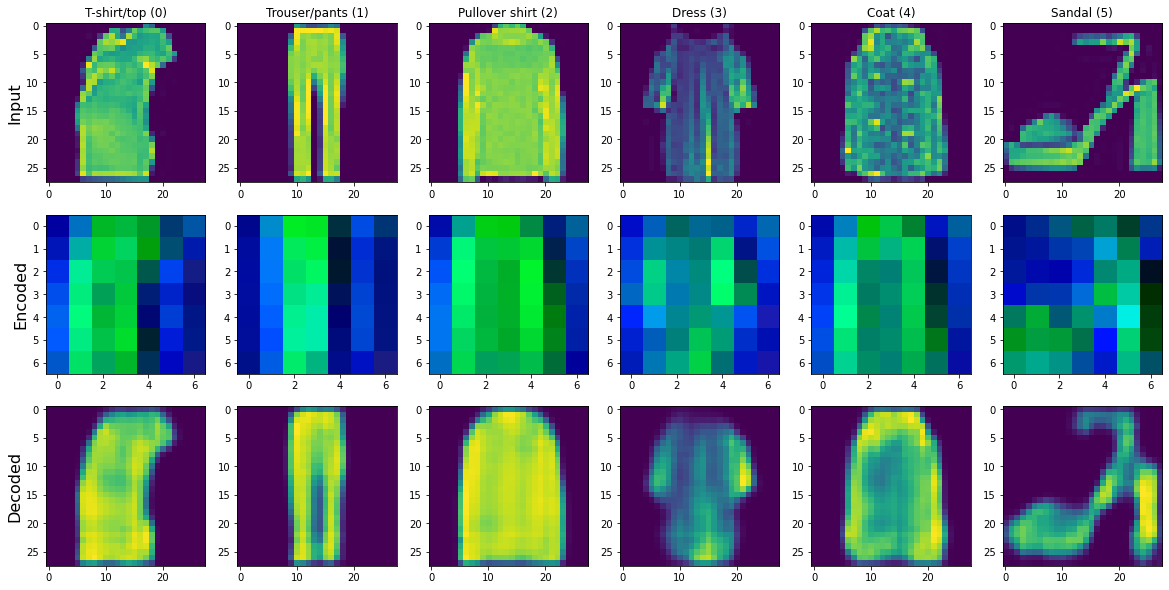

In [16]:
fig, AX = plt.subplots(3, 6, figsize=(20, 10))

np.random.seed(1234)
for i in range(6):
    index = np.argwhere(Y_test == i)[:,0]
    index = np.random.choice(index)
    label = Y_test[index]

    AX[0][i].imshow(X_test[index][...,0])
    AX[0][i].set_title(f'{objects[label]} ({label})')
    if not i: AX[0][i].set_ylabel('Input', size=16)

    encoded = encoder_c.predict(X_test[index][np.newaxis])
    
    AX[1][i].imshow(encoded[0]/encoded.max())
    if not i: AX[1][i].set_ylabel('Encoded', size=16)
    
    decoded = decoder_c.predict(encoded)
    
    AX[2][i].imshow(decoded.reshape(N1, N2))
    if not i: AX[2][i].set_ylabel('Decoded', size=16)